# Within-host single nucleotide variants 

**Date**: originally written on 2019-09-23, modified on 2020-01-09  
**Author**: Katarina Braun 


## Overview
- Look at the frequency of each SNP in each ferret over the course of within-host infections
- These SNVs were generated with the `Sniffles` pipeline 
- Concatenate dataframes for all index animals in each virus group (GD3 (including recombinant viruses) Anhui, CA04) so the columns headers of the dataframe will look like this: 
    1. Location
    2. SNV
    3. Effect = synonymous or nonsynonymous
    4. FREQ, day 1
    5. FREQ, day 3
    6. FREQ, day 5
    7. FREQ, day 7
    8. FREQ, avg
    9. FREQ, std dev 

**Visualize**: 
One scatterplot per gene where: 
- x axis contains gene length 
- y axis has FREQ 
- datapoints are plotted as closed if nonsynonymous and open if synonymous

### Note about HA numbering: 
For H7N9, I used H7 numbering. This numbering scheme matches the numbering scheme on Nextstrain (https://nextstrain.org/).  
For H1N1pdm, I use H1 numbering. Again, this numbering scheme matches the numbering scheme on Nextstrain. For clarity, I start counting amino acids at nucleotide #51, AA #18 (D). 


## for ease of use, here is a table with all ferrets, viruses, and timepoints where vRNA was collected

### Index ferrets 

| Ferret ID | Virus | Day 1 | Day 3 | Day 5 | Day 7 |
| - | - | - | - | - | - |
|1|Guangdong/17SF003|x|x|x|x|
|3|Guangdong/17SF003|x|x|x|x|
|5|Guangdong/17SF003|x|x|x|x|
|7|Guangdong/17SF003|x|x|x|x|
|9|R294-Guangdong|x|x|x|x|
|11|R294-Guangdong|x|x|
|13|R294-Guangdong|x|x|x|
|15|R294-Guangdong|x|x|x|x|
|17|K294-Guangdong|x|x|x|x|
|19|K294-Guangdong|x|x|x|
|21|K294-Guangdong|x|x|x|
|23|K294-Guangdong|x|x|x|x|
|25|Anhui1|x|x|x|x|
|27|Anhui1|x|x|x|x|
|29|Anhui1|x|x|x|x|
|31|Anhui1|x|x|x|
|33|CA04|x|x|x|x|
|35|CA04|x|x|x|

### Contact ferrets 

| Ferret ID | Virus | Day 3 | Day 5 | Day 7 | Day 9 | Day 11 | Day 13 | Day 15 |
| - | - | - | - | - | - | -|-|-|
|2|Guangdong/17SF003|
|4|Guangdong/17SF003|-|x|x|x|x|
|6|Guangdong/17SF003|
|8|Guangdong/17SF003|
|10|R294-Guangdong|x|x|x|x|
|12|R294-Guangdong|x|x|
|14|R294-Guangdong|
|16|R294-Guangdong|x|x|x|
|18|K294-Guangdong|-|-|-|-|x|x|x|
|20|K294-Guangdong|
|22|K294-Guangdong|x|x|x|x|
|24|K294-Guangdong|
|26|Anhui1|
|28|Anhui1|x|x|x|
|30|Anhui1|
|32|Anhui1|
|34|CA04|
|36|CA04|x|x|

### import modules and dependencies

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import glob
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import splitext
from functools import reduce
from pandas.api.types import is_numeric_dtype
import warnings
from pandas.core.common import SettingWithCopyWarning
from matplotlib.font_manager import FontProperties 
from matplotlib import cm
import itertools
from matplotlib import container
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib as mpl

### define functions

In [3]:
def load_dataframes(path):
    filelist = [os.path.splitext(file)[0] for file in os.listdir(path) if file.endswith('.csv')]
    list_of_DFs = []
    for file in filelist: 
        DF = path + '/' + file + '.csv'
        file = pd.read_csv(DF, header=0, sep='\t', low_memory=False)
        list_of_DFs.append(file)
    print(filelist)
    return(list_of_DFs)

#

In [4]:
# generate a list of dataframes, loaded from VCF files 
list_of_DFs = load_dataframes('../data_derived/iSNVs-over-time')

['Anhui_ferret25', 'Anhui_ferret29', 'Anhui_ferret27', 'Anhui_ferret28', 'Anhui_ferret31', 'CA04_ferret33', 'CA04_ferret35', 'CA04_ferret36', 'GD3_ferret1', 'GD3_ferret3', 'GD3_ferret4', 'GD3_ferret5', 'GD3_ferret7', 'rGD3_ferret9', 'rGD3_ferret10', 'rGD3_ferret11', 'rGD3_ferret12', 'rGD3_ferret13', 'rGD3_ferret15', 'rGD3_ferret16', 'rGD3_ferret17', 'rGD3_ferret18', 'rGD3_ferret19', 'rGD3_ferret21', 'rGD3_ferret22', 'rGD3_ferret23', 'pair_1_CA04', 'CA04_ferret1', 'CA04_ferret2', 'CA04_ferret3', 'CA04_ferret4', 'CA04_ferret6', 'CA04_ferret5', 'pair_1_Anhui', 'pair_2_CA04', 'pair_3_CA04', 'pair_4_CA04', 'pair_1_GD3', 'pair_1_rGD3', 'pair_2_rGD3', 'pair_3_rGD3', 'pair_4_rGD3', 'pair_5_rGD3']


In [5]:
def splice(ferret):
    splices = []
    
    df = pd.read_csv('../data_derived/iSNVs-over-time/' + ferret + '.csv', sep='\t')
    df = df.drop(['Unnamed: 0'], 1)
    
    df = df.replace(0,np.nan)
    df['avg'] = df.mean(axis=1)
    df['avg'] = df['avg']*100
    df_avg = df[['avg']].copy()
    df = df.drop('avg',1)

    df['min'] = df.min(axis=1)
    df['min'] = df['min']*100
    df_min = df[['min']].copy()
    df = df.drop('min',1)

    df['max'] = df.max(axis=1)
    df['max'] = df['max']*100
    df_max = df[['max']].copy()
    df = df.drop('max',1)

    df = df[['SNP']]

    dff = pd.concat([df, df_avg],axis=1)
    dff = pd.concat([dff, df_min],axis=1)
    df = pd.concat([dff, df_max],axis=1)

    df[['gene','nt','aa']] = df['SNP'].str.split('_',expand=True)
    df['nt'] = df['nt'].str.extract('(\d+)', expand=False)
    df['nt'] = pd.to_numeric(df['nt'])
    df['min'] = pd.to_numeric(df['min'])
    df['max'] = pd.to_numeric(df['max'])
    df = df[['SNP','nt','avg','min','max']]

    df_PB2 = df.loc[df['SNP'].str.contains('PB2')]
    df_PB2_ns = df_PB2.loc[~df_PB2['SNP'].str.contains('syn')]
    df_PB2_syn = df_PB2.loc[df_PB2['SNP'].str.contains('syn')]
    splices.append(df_PB2_ns) #0
    splices.append(df_PB2_syn) #1

    df_PB1 = df.loc[df['SNP'].str.contains("PB1")]
    df_PB1_ns = df_PB1.loc[~df_PB1['SNP'].str.contains("syn")]
    df_PB1_syn = df_PB1.loc[df_PB1['SNP'].str.contains("syn")]
    splices.append(df_PB1_ns) #2
    splices.append(df_PB1_syn) #3

    df_PA = df.loc[df['SNP'].str.contains("PA")]
    df_PA_ns = df_PA.loc[~df_PA['SNP'].str.contains("syn")]
    df_PA_syn = df_PA.loc[df_PA['SNP'].str.contains("syn")]
    splices.append(df_PA_ns) #4
    splices.append(df_PA_syn) #5

    df_HA = df.loc[df['SNP'].str.contains("HA")]
    df_HA_ns = df_HA.loc[~df_HA['SNP'].str.contains("syn")]
    df_HA_syn = df_HA.loc[df_HA['SNP'].str.contains("syn")]
    splices.append(df_HA_ns) #6
    splices.append(df_HA_syn) #7

    df_NP = df.loc[df['SNP'].str.contains("NP")]
    df_NP_ns = df_NP.loc[~df_NP['SNP'].str.contains("syn")]
    df_NP_syn = df_NP.loc[df_NP['SNP'].str.contains("syn")]
    splices.append(df_NP_ns) #8
    splices.append(df_NP_syn)#9

    df_NA = df.loc[df['SNP'].str.contains("NA")]
    df_NA_ns = df_NA.loc[~df_NA['SNP'].str.contains("syn")]
    df_NA_syn = df_NA.loc[df_NA['SNP'].str.contains("syn")]
    splices.append(df_NA_ns) #10
    splices.append(df_NA_syn) #11

    df_M1 = df.loc[df['SNP'].str.contains("M1")]
    df_M1_ns = df_M1.loc[~df_M1['SNP'].str.contains("syn")]
    df_M1_syn = df_M1.loc[df_M1['SNP'].str.contains("syn")]
    splices.append(df_M1_ns) #12
    splices.append(df_M1_syn) #13

    df_M2 = df.loc[df['SNP'].str.contains("M2")]
    df_M2_ns = df_M2.loc[~df_M2['SNP'].str.contains("syn")]
    df_M2_syn = df_M2.loc[df_M2['SNP'].str.contains("syn")]
    splices.append(df_M2_ns) #14
    splices.append(df_M2_syn) #15

    df_NS1 = df.loc[df['SNP'].str.contains("NS1")]
    df_NS1_ns = df_NS1.loc[~df_NS1['SNP'].str.contains("syn")]
    df_NS1_syn = df_NS1.loc[df_NS1['SNP'].str.contains("syn")]
    splices.append(df_NS1_ns) #16
    splices.append(df_NS1_syn) #17
    
    df_NEP = df.loc[df['SNP'].str.contains("NEP")]
    df_NEP_ns = df_NEP.loc[~df_NEP['SNP'].str.contains("syn")]
    df_NEP_syn = df_NEP.loc[df_NEP['SNP'].str.contains("syn")]
    splices.append(df_NEP_ns) #18
    splices.append(df_NEP_syn) #19
        
    return(splices)

#

In [6]:
# splice each ferret
Anhui_ferret25 = splice('Anhui_ferret25')
Anhui_ferret27 = splice('Anhui_ferret27')
Anhui_ferret28 = splice('Anhui_ferret28')
Anhui_ferret29 = splice('Anhui_ferret29')
Anhui_ferret31 = splice('Anhui_ferret31')

CA04_ferret33 = splice('CA04_ferret33')
CA04_ferret35 = splice('CA04_ferret35')
CA04_ferret36 = splice('CA04_ferret36')
CA04_ferret1 = splice('CA04_ferret1')
CA04_ferret2 = splice('CA04_ferret2')
CA04_ferret3 = splice('CA04_ferret3')
CA04_ferret4 = splice('CA04_ferret4')
CA04_ferret5 = splice('CA04_ferret5')
CA04_ferret6 = splice('CA04_ferret6')

GD3_ferret1 = splice('GD3_ferret1')
GD3_ferret3 = splice('GD3_ferret3')
GD3_ferret4 = splice('GD3_ferret4')
GD3_ferret5 = splice('GD3_ferret5')
GD3_ferret7 = splice('GD3_ferret7')

rGD3_ferret9 = splice('rGD3_ferret9')
rGD3_ferret10 = splice('rGD3_ferret10')
rGD3_ferret11 = splice('rGD3_ferret11')
rGD3_ferret12 = splice('rGD3_ferret12')
rGD3_ferret13 = splice('rGD3_ferret13')
rGD3_ferret15 = splice('rGD3_ferret15')
rGD3_ferret16 = splice('rGD3_ferret16')

rGD3_ferret17 = splice('rGD3_ferret17')
rGD3_ferret18 = splice('rGD3_ferret18')
rGD3_ferret19 = splice('rGD3_ferret19')
rGD3_ferret21 = splice('rGD3_ferret21')
rGD3_ferret22 = splice('rGD3_ferret22')
rGD3_ferret23 = splice('rGD3_ferret23')

In [7]:
Anhui_PB2_ns = pd.concat([Anhui_ferret25[0],Anhui_ferret27[0],Anhui_ferret28[0],Anhui_ferret29[0],Anhui_ferret31[0]])
Anhui_PB2_s = pd.concat([Anhui_ferret25[1],Anhui_ferret27[1],Anhui_ferret28[1],Anhui_ferret29[1],Anhui_ferret31[1]])

Anhui_PB1_ns = pd.concat([Anhui_ferret25[2],Anhui_ferret27[2],Anhui_ferret28[2],Anhui_ferret29[2],Anhui_ferret31[2]])
Anhui_PB1_s = pd.concat([Anhui_ferret25[3],Anhui_ferret27[3],Anhui_ferret28[3],Anhui_ferret29[3],Anhui_ferret31[3]])

Anhui_PA_ns = pd.concat([Anhui_ferret25[4],Anhui_ferret27[4],Anhui_ferret28[4],Anhui_ferret29[4],Anhui_ferret31[4]])
Anhui_PA_s = pd.concat([Anhui_ferret25[5],Anhui_ferret27[5],Anhui_ferret28[5],Anhui_ferret29[5],Anhui_ferret31[5]])

Anhui_HA_ns = pd.concat([Anhui_ferret25[6],Anhui_ferret27[6],Anhui_ferret28[6],Anhui_ferret29[6],Anhui_ferret31[6]])
Anhui_HA_s = pd.concat([Anhui_ferret25[7],Anhui_ferret27[7],Anhui_ferret28[7],Anhui_ferret29[7],Anhui_ferret31[7]])

Anhui_NP_ns = pd.concat([Anhui_ferret25[8],Anhui_ferret27[8],Anhui_ferret28[8],Anhui_ferret29[8],Anhui_ferret31[8]])
Anhui_NP_s = pd.concat([Anhui_ferret25[9],Anhui_ferret27[9],Anhui_ferret28[9],Anhui_ferret29[9],Anhui_ferret31[9]])

Anhui_NA_ns = pd.concat([Anhui_ferret25[10],Anhui_ferret27[10],Anhui_ferret28[10],Anhui_ferret29[10],Anhui_ferret31[10]])
Anhui_NA_s = pd.concat([Anhui_ferret25[11],Anhui_ferret27[11],Anhui_ferret28[11],Anhui_ferret29[11],Anhui_ferret31[11]])

Anhui_M1_ns = pd.concat([Anhui_ferret25[12],Anhui_ferret27[12],Anhui_ferret28[12],Anhui_ferret29[12],Anhui_ferret31[12]])
Anhui_M1_s = pd.concat([Anhui_ferret25[13],Anhui_ferret27[13],Anhui_ferret28[13],Anhui_ferret29[13],Anhui_ferret31[13]])

Anhui_M2_ns = pd.concat([Anhui_ferret25[14],Anhui_ferret27[14],Anhui_ferret28[14],Anhui_ferret29[14],Anhui_ferret31[14]])
Anhui_M2_s = pd.concat([Anhui_ferret25[15],Anhui_ferret27[15],Anhui_ferret28[15],Anhui_ferret29[15],Anhui_ferret31[15]])

Anhui_NS1_ns = pd.concat([Anhui_ferret25[16],Anhui_ferret27[16],Anhui_ferret28[16],Anhui_ferret29[16],Anhui_ferret31[16]])
Anhui_NS1_s = pd.concat([Anhui_ferret25[17],Anhui_ferret27[17],Anhui_ferret28[17],Anhui_ferret29[17],Anhui_ferret31[17]])

Anhui_NEP_ns = pd.concat([Anhui_ferret25[18],Anhui_ferret27[18],Anhui_ferret28[18],Anhui_ferret29[18],Anhui_ferret31[18]])
Anhui_NEP_s = pd.concat([Anhui_ferret25[19],Anhui_ferret27[19],Anhui_ferret28[19],Anhui_ferret29[19],Anhui_ferret31[19]])
                          
#

In [8]:
CA04_PB2_ns = pd.concat([CA04_ferret33[0],CA04_ferret35[0],CA04_ferret36[0],CA04_ferret1[0],CA04_ferret2[0],CA04_ferret3[0],CA04_ferret4[0],CA04_ferret5[0],CA04_ferret6[0]])
CA04_PB2_s = pd.concat([CA04_ferret33[1],CA04_ferret35[1],CA04_ferret36[1],CA04_ferret1[1],CA04_ferret2[1],CA04_ferret3[1],CA04_ferret4[1],CA04_ferret5[1],CA04_ferret6[1]])

CA04_PB1_ns = pd.concat([CA04_ferret33[2],CA04_ferret35[2],CA04_ferret36[2],CA04_ferret1[2],CA04_ferret2[2],CA04_ferret3[2],CA04_ferret4[2],CA04_ferret5[2],CA04_ferret6[2]])
CA04_PB1_s = pd.concat([CA04_ferret33[3],CA04_ferret35[3],CA04_ferret36[3],CA04_ferret1[3],CA04_ferret2[3],CA04_ferret3[3],CA04_ferret4[3],CA04_ferret5[3],CA04_ferret6[3]])

CA04_PA_ns = pd.concat([CA04_ferret33[4],CA04_ferret35[4],CA04_ferret36[4],CA04_ferret1[4],CA04_ferret2[4],CA04_ferret3[4],CA04_ferret4[4],CA04_ferret5[4],CA04_ferret6[4]])
CA04_PA_s = pd.concat([CA04_ferret33[5],CA04_ferret35[5],CA04_ferret36[5],CA04_ferret1[5],CA04_ferret2[5],CA04_ferret3[5],CA04_ferret4[5],CA04_ferret5[5],CA04_ferret6[5]])

CA04_HA_ns = pd.concat([CA04_ferret33[6],CA04_ferret35[6],CA04_ferret36[6],CA04_ferret1[6],CA04_ferret2[6],CA04_ferret3[6],CA04_ferret4[6],CA04_ferret5[6],CA04_ferret6[6]])
CA04_HA_s = pd.concat([CA04_ferret33[7],CA04_ferret35[7],CA04_ferret36[7],CA04_ferret1[7],CA04_ferret2[7],CA04_ferret3[7],CA04_ferret4[7],CA04_ferret5[7],CA04_ferret6[7]])

CA04_NP_ns = pd.concat([CA04_ferret33[8],CA04_ferret35[8],CA04_ferret36[8],CA04_ferret1[8],CA04_ferret2[8],CA04_ferret3[8],CA04_ferret4[8],CA04_ferret5[8],CA04_ferret6[8]])
CA04_NP_s = pd.concat([CA04_ferret33[9],CA04_ferret35[9],CA04_ferret36[9],CA04_ferret1[9],CA04_ferret2[9],CA04_ferret3[9],CA04_ferret4[9],CA04_ferret5[9],CA04_ferret6[9]])

CA04_NA_ns = pd.concat([CA04_ferret33[10],CA04_ferret35[10],CA04_ferret36[10],CA04_ferret1[10],CA04_ferret2[10],CA04_ferret3[10],CA04_ferret4[10],CA04_ferret5[10],CA04_ferret6[10]])
CA04_NA_s = pd.concat([CA04_ferret33[11],CA04_ferret35[11],CA04_ferret36[11],CA04_ferret1[11],CA04_ferret2[11],CA04_ferret3[11],CA04_ferret4[11],CA04_ferret5[11],CA04_ferret6[11]])

CA04_M1_ns = pd.concat([CA04_ferret33[12],CA04_ferret35[12],CA04_ferret36[12],CA04_ferret1[12],CA04_ferret2[12],CA04_ferret3[12],CA04_ferret4[12],CA04_ferret5[12],CA04_ferret6[12]])
CA04_M1_s = pd.concat([CA04_ferret33[13],CA04_ferret35[13],CA04_ferret36[13],CA04_ferret1[13],CA04_ferret2[13],CA04_ferret3[13],CA04_ferret4[13],CA04_ferret5[13],CA04_ferret6[13]])

CA04_M2_ns = pd.concat([CA04_ferret33[14],CA04_ferret35[14],CA04_ferret36[14],CA04_ferret1[14],CA04_ferret2[14],CA04_ferret3[14],CA04_ferret4[14],CA04_ferret5[14],CA04_ferret6[14]])
CA04_M2_s = pd.concat([CA04_ferret33[15],CA04_ferret35[15],CA04_ferret36[15],CA04_ferret1[15],CA04_ferret2[15],CA04_ferret3[15],CA04_ferret4[15],CA04_ferret5[15],CA04_ferret6[15]])

CA04_NS1_ns = pd.concat([CA04_ferret33[16],CA04_ferret35[16],CA04_ferret36[16],CA04_ferret1[16],CA04_ferret2[16],CA04_ferret3[16],CA04_ferret4[16],CA04_ferret5[16],CA04_ferret6[16]])
CA04_NS1_s = pd.concat([CA04_ferret33[17],CA04_ferret35[17],CA04_ferret36[17],CA04_ferret1[17],CA04_ferret2[17],CA04_ferret3[17],CA04_ferret4[17],CA04_ferret5[17],CA04_ferret6[17]])

CA04_NEP_ns = pd.concat([CA04_ferret33[18],CA04_ferret35[18],CA04_ferret36[18],CA04_ferret1[18],CA04_ferret2[18],CA04_ferret3[18],CA04_ferret4[18],CA04_ferret5[18],CA04_ferret6[18]])
CA04_NEP_s = pd.concat([CA04_ferret33[19],CA04_ferret35[19],CA04_ferret36[19],CA04_ferret1[19],CA04_ferret2[19],CA04_ferret3[19],CA04_ferret4[19],CA04_ferret5[19],CA04_ferret6[19]])

In [9]:
GD3_PB2_ns = pd.concat([GD3_ferret1[0],GD3_ferret3[0],GD3_ferret4[0],GD3_ferret5[0],GD3_ferret7[0]])
GD3_PB2_s = pd.concat([GD3_ferret1[1],GD3_ferret3[1],GD3_ferret4[1],GD3_ferret5[1],GD3_ferret7[1]])

GD3_PB1_ns = pd.concat([GD3_ferret1[2],GD3_ferret3[2],GD3_ferret4[2],GD3_ferret5[2],GD3_ferret7[2]])
GD3_PB1_s = pd.concat([GD3_ferret1[3],GD3_ferret3[3],GD3_ferret4[3],GD3_ferret5[3],GD3_ferret7[3]])

GD3_PA_ns = pd.concat([GD3_ferret1[4],GD3_ferret3[4],GD3_ferret4[4],GD3_ferret5[4],GD3_ferret7[4]])
GD3_PA_s = pd.concat([GD3_ferret1[5],GD3_ferret3[5],GD3_ferret4[5],GD3_ferret5[5],GD3_ferret7[5]])

GD3_HA_ns = pd.concat([GD3_ferret1[6],GD3_ferret3[6],GD3_ferret4[6],GD3_ferret5[6],GD3_ferret7[6]])
GD3_HA_s = pd.concat([GD3_ferret1[7],GD3_ferret3[7],GD3_ferret4[7],GD3_ferret5[7],GD3_ferret7[7]])

GD3_NP_ns = pd.concat([GD3_ferret1[8],GD3_ferret3[8],GD3_ferret4[8],GD3_ferret5[8],GD3_ferret7[8]])
GD3_NP_s = pd.concat([GD3_ferret1[9],GD3_ferret3[9],GD3_ferret4[9],GD3_ferret5[9],GD3_ferret7[9]])

GD3_NA_ns = pd.concat([GD3_ferret1[10],GD3_ferret3[10],GD3_ferret4[10],GD3_ferret5[10],GD3_ferret7[10]])
GD3_NA_s = pd.concat([GD3_ferret1[11],GD3_ferret3[11],GD3_ferret4[11],GD3_ferret5[11],GD3_ferret7[11]])

GD3_M1_ns = pd.concat([GD3_ferret1[12],GD3_ferret3[12],GD3_ferret4[12],GD3_ferret5[12],GD3_ferret7[12]])
GD3_M1_s = pd.concat([GD3_ferret1[13],GD3_ferret3[13],GD3_ferret4[13],GD3_ferret5[13],GD3_ferret7[13]])

GD3_M2_ns = pd.concat([GD3_ferret1[14],GD3_ferret3[14],GD3_ferret4[14],GD3_ferret5[14],GD3_ferret7[14]])
GD3_M2_s = pd.concat([GD3_ferret1[15],GD3_ferret3[15],GD3_ferret4[15],GD3_ferret5[15],GD3_ferret7[15]])

GD3_NS1_ns = pd.concat([GD3_ferret1[16],GD3_ferret3[16],GD3_ferret4[16],GD3_ferret5[16],GD3_ferret7[16]])
GD3_NS1_s = pd.concat([GD3_ferret1[17],GD3_ferret3[17],GD3_ferret4[17],GD3_ferret5[17],GD3_ferret7[17]])

GD3_NEP_ns = pd.concat([GD3_ferret1[18],GD3_ferret3[18],GD3_ferret4[18],GD3_ferret5[18],GD3_ferret7[18]])
GD3_NEP_s = pd.concat([GD3_ferret1[19],GD3_ferret3[19],GD3_ferret4[19],GD3_ferret5[19],GD3_ferret7[19]])

#

In [10]:
rGD3_PB2_ns = pd.concat([rGD3_ferret9[0],rGD3_ferret10[0],rGD3_ferret11[0],rGD3_ferret12[0],rGD3_ferret13[0],rGD3_ferret15[0],rGD3_ferret16[0],rGD3_ferret17[0],rGD3_ferret18[0],rGD3_ferret19[0],rGD3_ferret21[0],rGD3_ferret22[0],rGD3_ferret23[0]])
rGD3_PB2_s = pd.concat([rGD3_ferret9[1],rGD3_ferret10[1],rGD3_ferret11[1],rGD3_ferret12[1],rGD3_ferret13[1],rGD3_ferret15[1],rGD3_ferret16[1],rGD3_ferret17[1],rGD3_ferret18[1],rGD3_ferret19[1],rGD3_ferret21[1],rGD3_ferret22[1],rGD3_ferret23[1]])

rGD3_PB1_ns = pd.concat([rGD3_ferret9[2],rGD3_ferret10[2],rGD3_ferret11[2],rGD3_ferret12[2],rGD3_ferret13[2],rGD3_ferret15[2],rGD3_ferret16[2],rGD3_ferret17[2],rGD3_ferret18[2],rGD3_ferret19[2],rGD3_ferret21[2],rGD3_ferret22[2],rGD3_ferret23[2]])
rGD3_PB1_s = pd.concat([rGD3_ferret9[3],rGD3_ferret10[3],rGD3_ferret11[3],rGD3_ferret12[3],rGD3_ferret13[3],rGD3_ferret15[3],rGD3_ferret16[3],rGD3_ferret17[3],rGD3_ferret18[3],rGD3_ferret19[3],rGD3_ferret21[3],rGD3_ferret22[3],rGD3_ferret23[3]])

rGD3_PA_ns = pd.concat([rGD3_ferret9[4],rGD3_ferret10[4],rGD3_ferret11[4],rGD3_ferret12[4],rGD3_ferret13[4],rGD3_ferret15[4],rGD3_ferret16[4],rGD3_ferret17[4],rGD3_ferret18[4],rGD3_ferret19[4],rGD3_ferret21[4],rGD3_ferret22[4],rGD3_ferret23[4]])
rGD3_PA_s = pd.concat([rGD3_ferret9[5],rGD3_ferret10[5],rGD3_ferret11[5],rGD3_ferret12[5],rGD3_ferret13[5],rGD3_ferret15[5],rGD3_ferret16[5],rGD3_ferret17[5],rGD3_ferret18[5],rGD3_ferret19[5],rGD3_ferret21[5],rGD3_ferret22[5],rGD3_ferret23[5]])

rGD3_HA_ns = pd.concat([rGD3_ferret9[6],rGD3_ferret10[6],rGD3_ferret11[6],rGD3_ferret12[6],rGD3_ferret13[6],rGD3_ferret15[6],rGD3_ferret16[6],rGD3_ferret17[6],rGD3_ferret18[6],rGD3_ferret19[6],rGD3_ferret21[6],rGD3_ferret22[6],rGD3_ferret23[6]])
rGD3_HA_s = pd.concat([rGD3_ferret9[7],rGD3_ferret10[7],rGD3_ferret11[7],rGD3_ferret12[7],rGD3_ferret13[7],rGD3_ferret15[7],rGD3_ferret16[7],rGD3_ferret17[7],rGD3_ferret18[7],rGD3_ferret19[7],rGD3_ferret21[7],rGD3_ferret22[7],rGD3_ferret23[7]])

rGD3_NP_ns = pd.concat([rGD3_ferret9[8],rGD3_ferret10[8],rGD3_ferret11[8],rGD3_ferret12[8],rGD3_ferret13[8],rGD3_ferret15[8],rGD3_ferret16[8],rGD3_ferret17[8],rGD3_ferret18[8],rGD3_ferret19[8],rGD3_ferret21[8],rGD3_ferret22[8],rGD3_ferret23[8]])
rGD3_NP_s = pd.concat([rGD3_ferret9[9],rGD3_ferret10[9],rGD3_ferret11[9],rGD3_ferret12[9],rGD3_ferret13[9],rGD3_ferret15[9],rGD3_ferret16[9],rGD3_ferret17[9],rGD3_ferret18[9],rGD3_ferret19[9],rGD3_ferret21[9],rGD3_ferret22[9],rGD3_ferret23[9]])

rGD3_NA_ns = pd.concat([rGD3_ferret9[10],rGD3_ferret10[10],rGD3_ferret11[10],rGD3_ferret12[10],rGD3_ferret13[10],rGD3_ferret15[10],rGD3_ferret16[10],rGD3_ferret17[10],rGD3_ferret18[10],rGD3_ferret19[10],rGD3_ferret21[10],rGD3_ferret22[10],rGD3_ferret23[10]])
rGD3_NA_s = pd.concat([rGD3_ferret9[11],rGD3_ferret10[11],rGD3_ferret11[11],rGD3_ferret12[11],rGD3_ferret13[11],rGD3_ferret15[11],rGD3_ferret16[11],rGD3_ferret17[11],rGD3_ferret18[11],rGD3_ferret19[11],rGD3_ferret21[11],rGD3_ferret22[11],rGD3_ferret23[11]])

rGD3_M1_ns = pd.concat([rGD3_ferret9[12],rGD3_ferret10[12],rGD3_ferret11[12],rGD3_ferret12[12],rGD3_ferret13[12],rGD3_ferret15[12],rGD3_ferret16[12],rGD3_ferret17[12],rGD3_ferret18[12],rGD3_ferret19[12],rGD3_ferret21[12],rGD3_ferret22[12],rGD3_ferret23[12]])
rGD3_M1_s = pd.concat([rGD3_ferret9[13],rGD3_ferret10[13],rGD3_ferret11[13],rGD3_ferret12[13],rGD3_ferret13[13],rGD3_ferret15[13],rGD3_ferret16[13],rGD3_ferret17[13],rGD3_ferret18[13],rGD3_ferret19[13],rGD3_ferret21[13],rGD3_ferret22[13],rGD3_ferret23[13]])

rGD3_M2_ns = pd.concat([rGD3_ferret9[14],rGD3_ferret10[14],rGD3_ferret11[14],rGD3_ferret12[14],rGD3_ferret13[14],rGD3_ferret15[14],rGD3_ferret16[14],rGD3_ferret17[14],rGD3_ferret18[14],rGD3_ferret19[14],rGD3_ferret21[14],rGD3_ferret22[14],rGD3_ferret23[14]])
rGD3_M2_s = pd.concat([rGD3_ferret9[15],rGD3_ferret10[15],rGD3_ferret11[15],rGD3_ferret12[15],rGD3_ferret13[15],rGD3_ferret15[15],rGD3_ferret16[15],rGD3_ferret17[15],rGD3_ferret18[15],rGD3_ferret19[15],rGD3_ferret21[15],rGD3_ferret22[15],rGD3_ferret23[15]])

rGD3_NS1_ns = pd.concat([rGD3_ferret9[16],rGD3_ferret10[16],rGD3_ferret11[16],rGD3_ferret12[16],rGD3_ferret13[16],rGD3_ferret15[16],rGD3_ferret16[16],rGD3_ferret17[16],rGD3_ferret18[16],rGD3_ferret19[16],rGD3_ferret21[16],rGD3_ferret22[16],rGD3_ferret23[16]])
rGD3_NS1_s = pd.concat([rGD3_ferret9[17],rGD3_ferret10[17],rGD3_ferret11[17],rGD3_ferret12[17],rGD3_ferret13[17],rGD3_ferret15[17],rGD3_ferret16[17],rGD3_ferret17[17],rGD3_ferret18[17],rGD3_ferret19[17],rGD3_ferret21[17],rGD3_ferret22[17],rGD3_ferret23[17]])

rGD3_NEP_ns = pd.concat([rGD3_ferret9[18],rGD3_ferret10[18],rGD3_ferret11[18],rGD3_ferret12[18],rGD3_ferret13[18],rGD3_ferret15[18],rGD3_ferret16[18],rGD3_ferret17[18],rGD3_ferret18[18],rGD3_ferret19[18],rGD3_ferret21[18],rGD3_ferret22[18],rGD3_ferret23[18]])
rGD3_NEP_s = pd.concat([rGD3_ferret9[19],rGD3_ferret10[19],rGD3_ferret11[19],rGD3_ferret12[19],rGD3_ferret13[19],rGD3_ferret15[19],rGD3_ferret16[19],rGD3_ferret17[19],rGD3_ferret18[19],rGD3_ferret19[19],rGD3_ferret21[19],rGD3_ferret22[19],rGD3_ferret23[19]])


/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


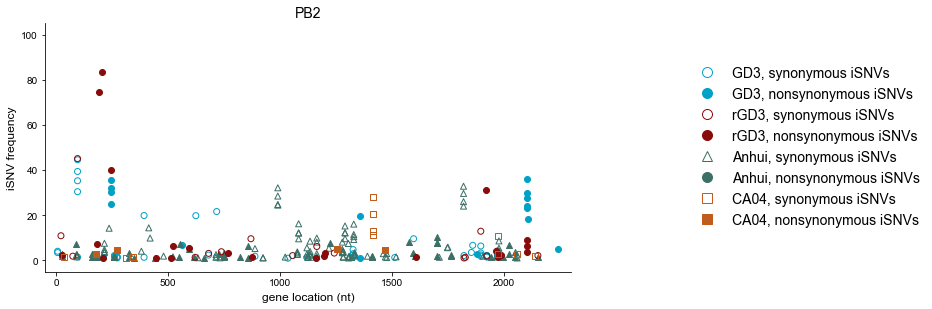

In [11]:
# define hex colors
GD3 = '#00A1C6'
rGD3 = '#890B0B'
Anhui = '#3C7067'
CA04 = '#C15D1A'

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(10,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 10)

ax1 = fig.add_subplot(gs[0,0:8]) #PB2

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# PB2 (ax1) (GD3, Anhui, and CA04)
ax1.set_title('PB2', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-5,105)
ax1.set_xlim(-50,2300)
ax1.set_xticks([0, 500, 1000, 1500, 2000])

ax1.scatter(x=GD3_PB2_s['nt'], y=GD3_PB2_s['avg'], marker='o', facecolors='none', edgecolors=GD3)
ax1.scatter(x=GD3_PB2_ns['nt'], y=GD3_PB2_ns['avg'], marker='o', facecolors=GD3, edgecolors=GD3)

ax1.scatter(x=Anhui_PB2_s['nt'], y=Anhui_PB2_s['avg'], marker='^', facecolors='none', edgecolors=Anhui)
ax1.scatter(x=Anhui_PB2_ns['nt'], y=Anhui_PB2_ns['avg'], marker='^', facecolors=Anhui, edgecolors=Anhui)

ax1.scatter(x=rGD3_PB2_s['nt'], y=rGD3_PB2_s['avg'], marker='o', facecolors='none', edgecolors=rGD3)
ax1.scatter(x=rGD3_PB2_ns['nt'], y=rGD3_PB2_ns['avg'], marker='o', facecolors=rGD3, edgecolors=rGD3)

ax1.scatter(x=CA04_PB2_s['nt'], y=CA04_PB2_s['avg'], marker='s', facecolors='none', edgecolors=CA04)
ax1.scatter(x=CA04_PB2_ns['nt'], y=CA04_PB2_ns['avg'], marker='s', facecolors=CA04, edgecolors=CA04)

ax1.set_ylabel('iSNV frequency', fontname='Arial', fontsize=12)
ax1.set_xlabel('gene location (nt)', fontname='Arial', fontsize=12)

# add a legend to this plot
GD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, synonymous iSNVs')
GD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=GD3, markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, nonsynonymous iSNVs')
rGD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, synonymous iSNVs')
rGD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=rGD3, markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, nonsynonymous iSNVs')
Anhui_syn = mlines.Line2D([], [], marker='^', markerfacecolor='None', markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, synonymous iSNVs')
Anhui_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=Anhui, markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, nonsynonymous iSNVs')
CA04_syn = mlines.Line2D([], [], marker='s', markerfacecolor='None', markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, synonymous iSNVs')
CA04_nonsyn = mlines.Line2D([], [], marker='s', markerfacecolor=CA04, markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, nonsynonymous iSNVs')

# line = mlines.Line2D([], [], marker='|', linestyle='None', color='grey', label='SNV freq range: average - max', markersize=14)

fig.legend(handles=[GD3_syn, GD3_nonsyn, rGD3_syn, rGD3_nonsyn, Anhui_syn, Anhui_nonsyn, CA04_syn, CA04_nonsyn], frameon=False, fontsize=14, bbox_to_anchor=(1.3,0.9))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/iSNVs_by_gene/PB2.pdf", bbox_inches='tight', dpi=300)


/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


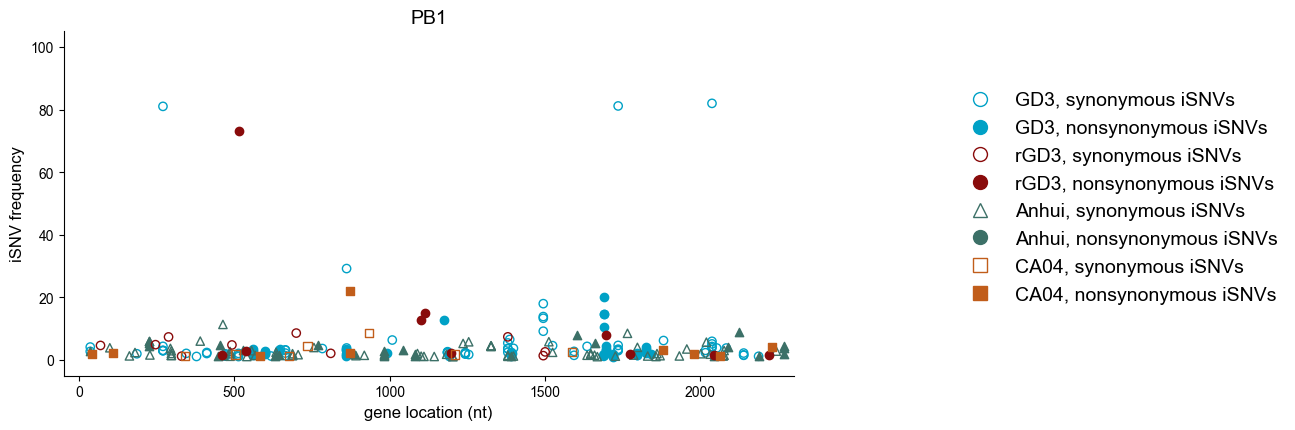

In [12]:
# define hex colors
GD3 = '#00A1C6'
rGD3 = '#890B0B'
Anhui = '#3C7067'
CA04 = '#C15D1A'

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(10,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 10)

ax1 = fig.add_subplot(gs[0,0:8]) #PB1

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# PB1 (ax1) (GD3, Anhui, and CA04)
ax1.set_title('PB1', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-5,105)
ax1.set_xlim(-50,2300)
ax1.set_xticks([0, 500, 1000, 1500, 2000])

ax1.scatter(x=GD3_PB1_s['nt'], y=GD3_PB1_s['avg'], marker='o', facecolors='none', edgecolors=GD3)
ax1.scatter(x=GD3_PB1_ns['nt'], y=GD3_PB1_ns['avg'], marker='o', facecolors=GD3, edgecolors=GD3)

ax1.scatter(x=Anhui_PB1_s['nt'], y=Anhui_PB1_s['avg'], marker='^', facecolors='none', edgecolors=Anhui)
ax1.scatter(x=Anhui_PB1_ns['nt'], y=Anhui_PB1_ns['avg'], marker='^', facecolors=Anhui, edgecolors=Anhui)

ax1.scatter(x=rGD3_PB1_s['nt'], y=rGD3_PB1_s['avg'], marker='o', facecolors='none', edgecolors=rGD3)
ax1.scatter(x=rGD3_PB1_ns['nt'], y=rGD3_PB1_ns['avg'], marker='o', facecolors=rGD3, edgecolors=rGD3)

ax1.scatter(x=CA04_PB1_s['nt'], y=CA04_PB1_s['avg'], marker='s', facecolors='none', edgecolors=CA04)
ax1.scatter(x=CA04_PB1_ns['nt'], y=CA04_PB1_ns['avg'], marker='s', facecolors=CA04, edgecolors=CA04)

ax1.set_ylabel('iSNV frequency', fontname='Arial', fontsize=12)
ax1.set_xlabel('gene location (nt)', fontname='Arial', fontsize=12)

# add a legend to this plot
GD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, synonymous iSNVs')
GD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=GD3, markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, nonsynonymous iSNVs')
rGD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, synonymous iSNVs')
rGD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=rGD3, markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, nonsynonymous iSNVs')
Anhui_syn = mlines.Line2D([], [], marker='^', markerfacecolor='None', markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, synonymous iSNVs')
Anhui_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=Anhui, markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, nonsynonymous iSNVs')
CA04_syn = mlines.Line2D([], [], marker='s', markerfacecolor='None', markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, synonymous iSNVs')
CA04_nonsyn = mlines.Line2D([], [], marker='s', markerfacecolor=CA04, markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, nonsynonymous iSNVs')

# line = mlines.Line2D([], [], marker='|', linestyle='None', color='grey', label='SNV freq range: average - max', markersize=14)
fig.legend(handles=[GD3_syn, GD3_nonsyn, rGD3_syn, rGD3_nonsyn, Anhui_syn, Anhui_nonsyn, CA04_syn, CA04_nonsyn], frameon=False, fontsize=14, bbox_to_anchor=(1.3,0.9))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/iSNVs_by_gene/PB1.pdf", bbox_inches='tight', dpi=300)


/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


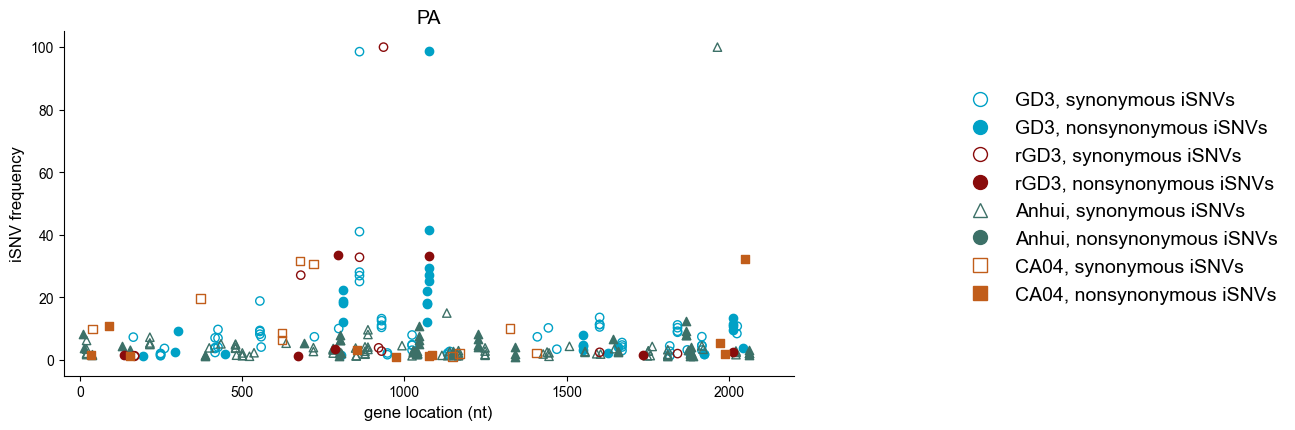

In [13]:
# define hex colors
GD3 = '#00A1C6'
rGD3 = '#890B0B'
Anhui = '#3C7067'
CA04 = '#C15D1A'

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(10,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 10)

ax1 = fig.add_subplot(gs[0,0:8]) #PA

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# PA (ax1) (GD3, Anhui, and CA04)
ax1.set_title('PA', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-5,105)
ax1.set_xlim(-50,2200)
ax1.set_xticks([0, 500, 1000, 1500, 2000])

ax1.scatter(x=GD3_PA_s['nt'], y=GD3_PA_s['avg'], marker='o', facecolors='none', edgecolors=GD3)
ax1.scatter(x=GD3_PA_ns['nt'], y=GD3_PA_ns['avg'], marker='o', facecolors=GD3, edgecolors=GD3)

ax1.scatter(x=Anhui_PA_s['nt'], y=Anhui_PA_s['avg'], marker='^', facecolors='none', edgecolors=Anhui)
ax1.scatter(x=Anhui_PA_ns['nt'], y=Anhui_PA_ns['avg'], marker='^', facecolors=Anhui, edgecolors=Anhui)

ax1.scatter(x=rGD3_PA_s['nt'], y=rGD3_PA_s['avg'], marker='o', facecolors='none', edgecolors=rGD3)
ax1.scatter(x=rGD3_PA_ns['nt'], y=rGD3_PA_ns['avg'], marker='o', facecolors=rGD3, edgecolors=rGD3)

ax1.scatter(x=CA04_PA_s['nt'], y=CA04_PA_s['avg'], marker='s', facecolors='none', edgecolors=CA04)
ax1.scatter(x=CA04_PA_ns['nt'], y=CA04_PA_ns['avg'], marker='s', facecolors=CA04, edgecolors=CA04)

ax1.set_ylabel('iSNV frequency', fontname='Arial', fontsize=12)
ax1.set_xlabel('gene location (nt)', fontname='Arial', fontsize=12)


# add a legend to this plot
GD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, synonymous iSNVs')
GD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=GD3, markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, nonsynonymous iSNVs')
rGD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, synonymous iSNVs')
rGD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=rGD3, markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, nonsynonymous iSNVs')
Anhui_syn = mlines.Line2D([], [], marker='^', markerfacecolor='None', markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, synonymous iSNVs')
Anhui_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=Anhui, markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, nonsynonymous iSNVs')
CA04_syn = mlines.Line2D([], [], marker='s', markerfacecolor='None', markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, synonymous iSNVs')
CA04_nonsyn = mlines.Line2D([], [], marker='s', markerfacecolor=CA04, markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, nonsynonymous iSNVs')

# line = mlines.Line2D([], [], marker='|', linestyle='None', color='grey', label='SNV freq range: average - max', markersize=14)
fig.legend(handles=[GD3_syn, GD3_nonsyn, rGD3_syn, rGD3_nonsyn, Anhui_syn, Anhui_nonsyn, CA04_syn, CA04_nonsyn], frameon=False, fontsize=14, bbox_to_anchor=(1.3,0.9))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/iSNVs_by_gene/PA.pdf", bbox_inches='tight', dpi=300)


/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


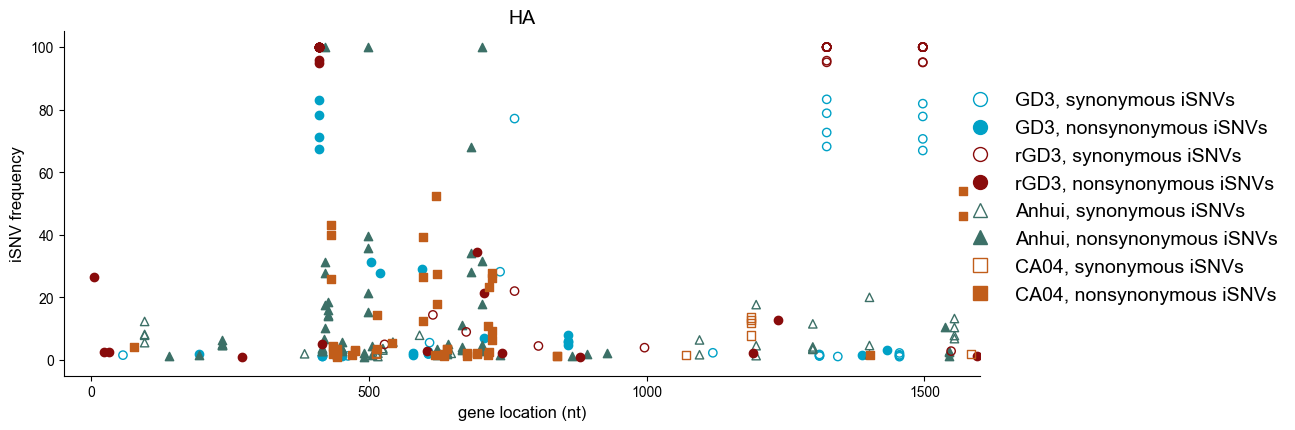

In [14]:
# define hex colors
GD3 = '#00A1C6'
rGD3 = '#890B0B'
Anhui = '#3C7067'
CA04 = '#C15D1A'

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(10,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 8)

ax1 = fig.add_subplot(gs[0,0:8]) #HA

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# HA (ax1) (GD3, Anhui, and CA04)
ax1.set_title('HA', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-5,105)
ax1.set_xlim(-50,1600)
ax1.set_xticks([0, 500, 1000, 1500])

ax1.scatter(x=GD3_HA_s['nt'], y=GD3_HA_s['avg'], marker='o', facecolors='none', edgecolors=GD3)
ax1.scatter(x=GD3_HA_ns['nt'], y=GD3_HA_ns['avg'], marker='o', facecolors=GD3, edgecolors=GD3)

ax1.scatter(x=Anhui_HA_s['nt'], y=Anhui_HA_s['avg'], marker='^', facecolors='none', edgecolors=Anhui)
ax1.scatter(x=Anhui_HA_ns['nt'], y=Anhui_HA_ns['avg'], marker='^', facecolors=Anhui, edgecolors=Anhui)

ax1.scatter(x=rGD3_HA_s['nt'], y=rGD3_HA_s['avg'], marker='o', facecolors='none', edgecolors=rGD3)
ax1.scatter(x=rGD3_HA_ns['nt'], y=rGD3_HA_ns['avg'], marker='o', facecolors=rGD3, edgecolors=rGD3)

ax1.scatter(x=CA04_HA_s['nt'], y=CA04_HA_s['avg'], marker='s', facecolors='none', edgecolors=CA04)
ax1.scatter(x=CA04_HA_ns['nt'], y=CA04_HA_ns['avg'], marker='s', facecolors=CA04, edgecolors=CA04)

ax1.set_ylabel('iSNV frequency', fontname='Arial', fontsize=12)
ax1.set_xlabel('gene location (nt)', fontname='Arial', fontsize=12)


# add a legend to this plot
GD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, synonymous iSNVs')
GD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=GD3, markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, nonsynonymous iSNVs')
rGD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, synonymous iSNVs')
rGD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=rGD3, markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, nonsynonymous iSNVs')
Anhui_syn = mlines.Line2D([], [], marker='^', markerfacecolor='None', markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, synonymous iSNVs')
Anhui_nonsyn = mlines.Line2D([], [], marker='^', markerfacecolor=Anhui, markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, nonsynonymous iSNVs')
CA04_syn = mlines.Line2D([], [], marker='s', markerfacecolor='None', markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, synonymous iSNVs')
CA04_nonsyn = mlines.Line2D([], [], marker='s', markerfacecolor=CA04, markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, nonsynonymous iSNVs')

# line = mlines.Line2D([], [], marker='|', linestyle='None', color='grey', label='SNV freq range: average - max', markersize=14)
fig.legend(handles=[GD3_syn, GD3_nonsyn, rGD3_syn, rGD3_nonsyn, Anhui_syn, Anhui_nonsyn, CA04_syn, CA04_nonsyn], frameon=False, fontsize=14, bbox_to_anchor=(1.3,0.9))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/iSNVs_by_gene/HA.pdf", bbox_inches='tight', dpi=300)


/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


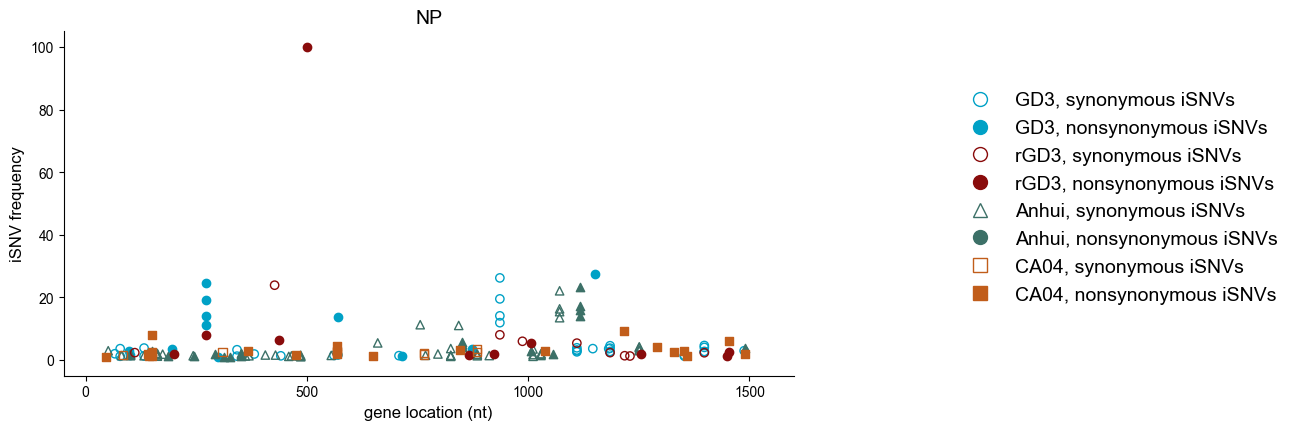

In [15]:
# define hex colors
GD3 = '#00A1C6'
rGD3 = '#890B0B'
Anhui = '#3C7067'
CA04 = '#C15D1A'

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(10,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 10)

ax1 = fig.add_subplot(gs[0,0:8]) #NP

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# NP (ax1) (GD3, Anhui, and CA04)
ax1.set_title('NP', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-5,105)
ax1.set_xlim(-50,1600)
ax1.set_xticks([0, 500, 1000, 1500])

ax1.scatter(x=GD3_NP_s['nt'], y=GD3_NP_s['avg'], marker='o', facecolors='none', edgecolors=GD3)
ax1.scatter(x=GD3_NP_ns['nt'], y=GD3_NP_ns['avg'], marker='o', facecolors=GD3, edgecolors=GD3)

ax1.scatter(x=Anhui_NP_s['nt'], y=Anhui_NP_s['avg'], marker='^', facecolors='none', edgecolors=Anhui)
ax1.scatter(x=Anhui_NP_ns['nt'], y=Anhui_NP_ns['avg'], marker='^', facecolors=Anhui, edgecolors=Anhui)

ax1.scatter(x=rGD3_NP_s['nt'], y=rGD3_NP_s['avg'], marker='o', facecolors='none', edgecolors=rGD3)
ax1.scatter(x=rGD3_NP_ns['nt'], y=rGD3_NP_ns['avg'], marker='o', facecolors=rGD3, edgecolors=rGD3)

ax1.scatter(x=CA04_NP_s['nt'], y=CA04_NP_s['avg'], marker='s', facecolors='none', edgecolors=CA04)
ax1.scatter(x=CA04_NP_ns['nt'], y=CA04_NP_ns['avg'], marker='s', facecolors=CA04, edgecolors=CA04)

ax1.set_ylabel('iSNV frequency', fontname='Arial', fontsize=12)
ax1.set_xlabel('gene location (nt)', fontname='Arial', fontsize=12)


# add a legend to this plot
GD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, synonymous iSNVs')
GD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=GD3, markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, nonsynonymous iSNVs')
rGD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, synonymous iSNVs')
rGD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=rGD3, markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, nonsynonymous iSNVs')
Anhui_syn = mlines.Line2D([], [], marker='^', markerfacecolor='None', markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, synonymous iSNVs')
Anhui_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=Anhui, markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, nonsynonymous iSNVs')
CA04_syn = mlines.Line2D([], [], marker='s', markerfacecolor='None', markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, synonymous iSNVs')
CA04_nonsyn = mlines.Line2D([], [], marker='s', markerfacecolor=CA04, markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, nonsynonymous iSNVs')

# line = mlines.Line2D([], [], marker='|', linestyle='None', color='grey', label='SNV freq range: average - max', markersize=14)
fig.legend(handles=[GD3_syn, GD3_nonsyn, rGD3_syn, rGD3_nonsyn, Anhui_syn, Anhui_nonsyn, CA04_syn, CA04_nonsyn], frameon=False, fontsize=14, bbox_to_anchor=(1.3,0.9))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/iSNVs_by_gene/NP.pdf", bbox_inches='tight', dpi=300)


/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


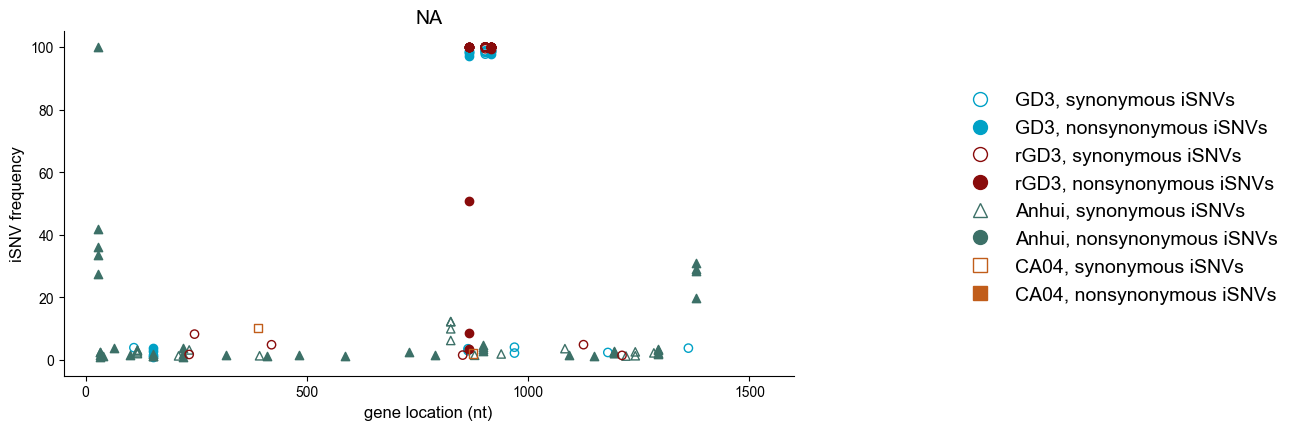

In [16]:
# define hex colors
GD3 = '#00A1C6'
rGD3 = '#890B0B'
Anhui = '#3C7067'
CA04 = '#C15D1A'

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(10,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 10)

ax1 = fig.add_subplot(gs[0,0:8]) #NA

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# NA (ax1) (GD3, Anhui, and CA04)
ax1.set_title('NA', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-5,105)
ax1.set_xlim(-50,1600)
ax1.set_xticks([0, 500, 1000, 1500])

ax1.scatter(x=GD3_NA_s['nt'], y=GD3_NA_s['avg'], marker='o', facecolors='none', edgecolors=GD3)
ax1.scatter(x=GD3_NA_ns['nt'], y=GD3_NA_ns['avg'], marker='o', facecolors=GD3, edgecolors=GD3)

ax1.scatter(x=Anhui_NA_s['nt'], y=Anhui_NA_s['avg'], marker='^', facecolors='none', edgecolors=Anhui)
ax1.scatter(x=Anhui_NA_ns['nt'], y=Anhui_NA_ns['avg'], marker='^', facecolors=Anhui, edgecolors=Anhui)

ax1.scatter(x=rGD3_NA_s['nt'], y=rGD3_NA_s['avg'], marker='o', facecolors='none', edgecolors=rGD3)
ax1.scatter(x=rGD3_NA_ns['nt'], y=rGD3_NA_ns['avg'], marker='o', facecolors=rGD3, edgecolors=rGD3)

ax1.scatter(x=CA04_NA_s['nt'], y=CA04_NA_s['avg'], marker='s', facecolors='none', edgecolors=CA04)
ax1.scatter(x=CA04_NA_ns['nt'], y=CA04_NA_ns['avg'], marker='s', facecolors=CA04, edgecolors=CA04)

ax1.set_ylabel('iSNV frequency', fontname='Arial', fontsize=12)
ax1.set_xlabel('gene location (nt)', fontname='Arial', fontsize=12)


# add a legend to this plot
GD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, synonymous iSNVs')
GD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=GD3, markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, nonsynonymous iSNVs')
rGD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, synonymous iSNVs')
rGD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=rGD3, markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, nonsynonymous iSNVs')
Anhui_syn = mlines.Line2D([], [], marker='^', markerfacecolor='None', markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, synonymous iSNVs')
Anhui_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=Anhui, markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, nonsynonymous iSNVs')
CA04_syn = mlines.Line2D([], [], marker='s', markerfacecolor='None', markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, synonymous iSNVs')
CA04_nonsyn = mlines.Line2D([], [], marker='s', markerfacecolor=CA04, markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, nonsynonymous iSNVs')

# line = mlines.Line2D([], [], marker='|', linestyle='None', color='grey', label='SNV freq range: average - max', markersize=14)
fig.legend(handles=[GD3_syn, GD3_nonsyn, rGD3_syn, rGD3_nonsyn, Anhui_syn, Anhui_nonsyn, CA04_syn, CA04_nonsyn], frameon=False, fontsize=14, bbox_to_anchor=(1.3,0.9))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/iSNVs_by_gene/NA.pdf", bbox_inches='tight', dpi=300)


/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


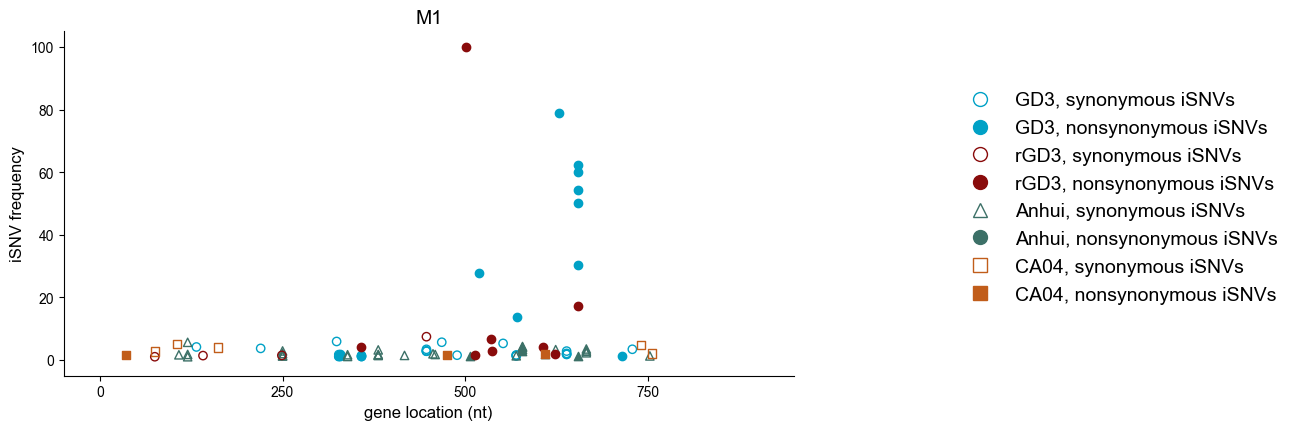

In [17]:
# define hex colors
GD3 = '#00A1C6'
rGD3 = '#890B0B'
Anhui = '#3C7067'
CA04 = '#C15D1A'

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(10,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 10)

ax1 = fig.add_subplot(gs[0,0:8]) #M1

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# M1 (ax1) (GD3, Anhui, and CA04)
ax1.set_title('M1', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-5,105)
ax1.set_xlim(-50,950)
ax1.set_xticks([0, 250, 500, 750])

ax1.scatter(x=GD3_M1_s['nt'], y=GD3_M1_s['avg'], marker='o', facecolors='none', edgecolors=GD3)
ax1.scatter(x=GD3_M1_ns['nt'], y=GD3_M1_ns['avg'], marker='o', facecolors=GD3, edgecolors=GD3)

ax1.scatter(x=Anhui_M1_s['nt'], y=Anhui_M1_s['avg'], marker='^', facecolors='none', edgecolors=Anhui)
ax1.scatter(x=Anhui_M1_ns['nt'], y=Anhui_M1_ns['avg'], marker='^', facecolors=Anhui, edgecolors=Anhui)

ax1.scatter(x=rGD3_M1_s['nt'], y=rGD3_M1_s['avg'], marker='o', facecolors='none', edgecolors=rGD3)
ax1.scatter(x=rGD3_M1_ns['nt'], y=rGD3_M1_ns['avg'], marker='o', facecolors=rGD3, edgecolors=rGD3)

ax1.scatter(x=CA04_M1_s['nt'], y=CA04_M1_s['avg'], marker='s', facecolors='none', edgecolors=CA04)
ax1.scatter(x=CA04_M1_ns['nt'], y=CA04_M1_ns['avg'], marker='s', facecolors=CA04, edgecolors=CA04)

ax1.set_ylabel('iSNV frequency', fontname='Arial', fontsize=12)
ax1.set_xlabel('gene location (nt)', fontname='Arial', fontsize=12)


# add a legend to this plot
GD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, synonymous iSNVs')
GD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=GD3, markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, nonsynonymous iSNVs')
rGD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, synonymous iSNVs')
rGD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=rGD3, markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, nonsynonymous iSNVs')
Anhui_syn = mlines.Line2D([], [], marker='^', markerfacecolor='None', markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, synonymous iSNVs')
Anhui_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=Anhui, markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, nonsynonymous iSNVs')
CA04_syn = mlines.Line2D([], [], marker='s', markerfacecolor='None', markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, synonymous iSNVs')
CA04_nonsyn = mlines.Line2D([], [], marker='s', markerfacecolor=CA04, markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, nonsynonymous iSNVs')

# line = mlines.Line2D([], [], marker='|', linestyle='None', color='grey', label='SNV freq range: average - max', markersize=14)
fig.legend(handles=[GD3_syn, GD3_nonsyn, rGD3_syn, rGD3_nonsyn, Anhui_syn, Anhui_nonsyn, CA04_syn, CA04_nonsyn], frameon=False, fontsize=14, bbox_to_anchor=(1.3,0.9))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/iSNVs_by_gene/M1.pdf", bbox_inches='tight', dpi=300)


/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


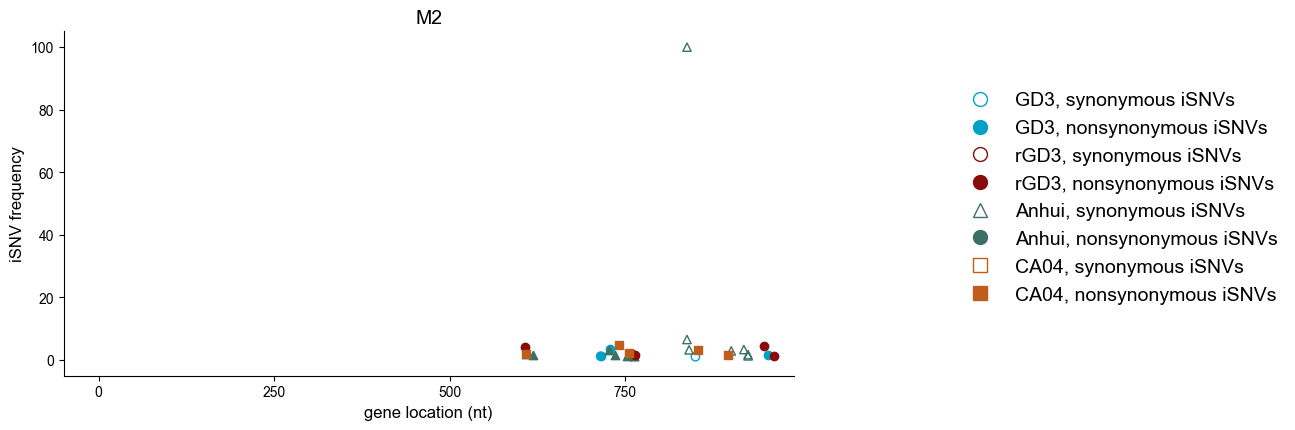

In [18]:
# define hex colors
GD3 = '#00A1C6'
rGD3 = '#890B0B'
Anhui = '#3C7067'
CA04 = '#C15D1A'

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(10,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 10)

ax1 = fig.add_subplot(gs[0,0:8]) #M2

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# M2 (ax1) (GD3, Anhui, and CA04)
ax1.set_title('M2', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-5,105)
ax1.set_xlim(-50,990)
ax1.set_xticks([0, 250, 500, 750])

ax1.scatter(x=GD3_M2_s['nt'], y=GD3_M2_s['avg'], marker='o', facecolors='none', edgecolors=GD3)
ax1.scatter(x=GD3_M2_ns['nt'], y=GD3_M2_ns['avg'], marker='o', facecolors=GD3, edgecolors=GD3)

ax1.scatter(x=Anhui_M2_s['nt'], y=Anhui_M2_s['avg'], marker='^', facecolors='none', edgecolors=Anhui)
ax1.scatter(x=Anhui_M2_ns['nt'], y=Anhui_M2_ns['avg'], marker='^', facecolors=Anhui, edgecolors=Anhui)

ax1.scatter(x=rGD3_M2_s['nt'], y=rGD3_M2_s['avg'], marker='o', facecolors='none', edgecolors=rGD3)
ax1.scatter(x=rGD3_M2_ns['nt'], y=rGD3_M2_ns['avg'], marker='o', facecolors=rGD3, edgecolors=rGD3)

ax1.scatter(x=CA04_M2_s['nt'], y=CA04_M2_s['avg'], marker='s', facecolors='none', edgecolors=CA04)
ax1.scatter(x=CA04_M2_ns['nt'], y=CA04_M2_ns['avg'], marker='s', facecolors=CA04, edgecolors=CA04)

ax1.set_ylabel('iSNV frequency', fontname='Arial', fontsize=12)
ax1.set_xlabel('gene location (nt)', fontname='Arial', fontsize=12)


# add a legend to this plot
GD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, synonymous iSNVs')
GD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=GD3, markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, nonsynonymous iSNVs')
rGD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, synonymous iSNVs')
rGD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=rGD3, markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, nonsynonymous iSNVs')
Anhui_syn = mlines.Line2D([], [], marker='^', markerfacecolor='None', markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, synonymous iSNVs')
Anhui_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=Anhui, markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, nonsynonymous iSNVs')
CA04_syn = mlines.Line2D([], [], marker='s', markerfacecolor='None', markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, synonymous iSNVs')
CA04_nonsyn = mlines.Line2D([], [], marker='s', markerfacecolor=CA04, markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, nonsynonymous iSNVs')

# line = mlines.Line2D([], [], marker='|', linestyle='None', color='grey', label='SNV freq range: average - max', markersize=14)
fig.legend(handles=[GD3_syn, GD3_nonsyn, rGD3_syn, rGD3_nonsyn, Anhui_syn, Anhui_nonsyn, CA04_syn, CA04_nonsyn], frameon=False, fontsize=14, bbox_to_anchor=(1.3,0.9))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/iSNVs_by_gene/M2.pdf", bbox_inches='tight', dpi=300)


/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


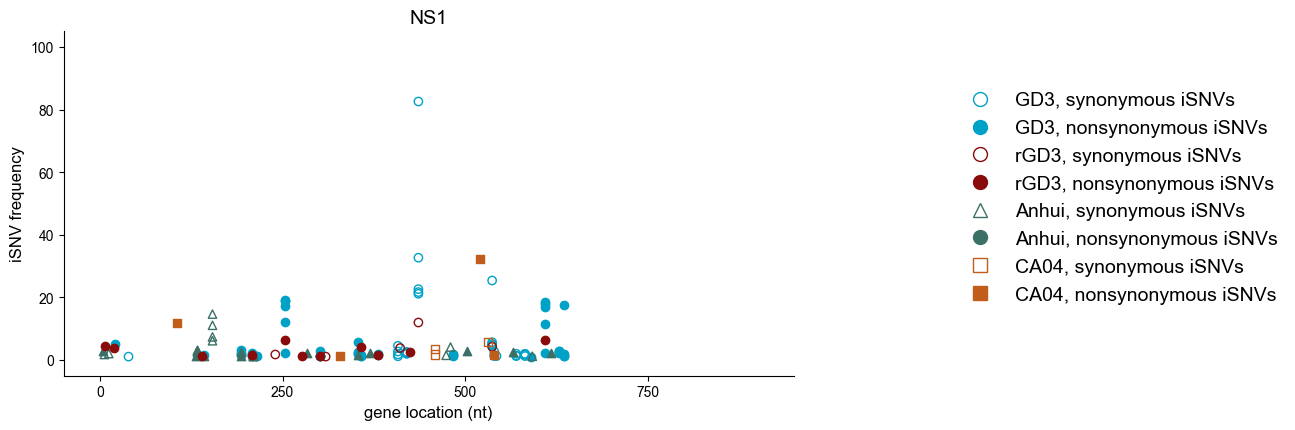

In [19]:
# define hex colors
GD3 = '#00A1C6'
rGD3 = '#890B0B'
Anhui = '#3C7067'
CA04 = '#C15D1A'

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(10,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 10)

ax1 = fig.add_subplot(gs[0,0:8]) #NS1

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# NS1 (ax1) (GD3, Anhui, and CA04)
ax1.set_title('NS1', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-5,105)
ax1.set_xlim(-50,950)
ax1.set_xticks([0, 250, 500, 750])

ax1.scatter(x=GD3_NS1_s['nt'], y=GD3_NS1_s['avg'], marker='o', facecolors='none', edgecolors=GD3)
ax1.scatter(x=GD3_NS1_ns['nt'], y=GD3_NS1_ns['avg'], marker='o', facecolors=GD3, edgecolors=GD3)

ax1.scatter(x=Anhui_NS1_s['nt'], y=Anhui_NS1_s['avg'], marker='^', facecolors='none', edgecolors=Anhui)
ax1.scatter(x=Anhui_NS1_ns['nt'], y=Anhui_NS1_ns['avg'], marker='^', facecolors=Anhui, edgecolors=Anhui)

ax1.scatter(x=rGD3_NS1_s['nt'], y=rGD3_NS1_s['avg'], marker='o', facecolors='none', edgecolors=rGD3)
ax1.scatter(x=rGD3_NS1_ns['nt'], y=rGD3_NS1_ns['avg'], marker='o', facecolors=rGD3, edgecolors=rGD3)

ax1.scatter(x=CA04_NS1_s['nt'], y=CA04_NS1_s['avg'], marker='s', facecolors='none', edgecolors=CA04)
ax1.scatter(x=CA04_NS1_ns['nt'], y=CA04_NS1_ns['avg'], marker='s', facecolors=CA04, edgecolors=CA04)

ax1.set_ylabel('iSNV frequency', fontname='Arial', fontsize=12)
ax1.set_xlabel('gene location (nt)', fontname='Arial', fontsize=12)


# add a legend to this plot
GD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, synonymous iSNVs')
GD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=GD3, markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, nonsynonymous iSNVs')
rGD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, synonymous iSNVs')
rGD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=rGD3, markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, nonsynonymous iSNVs')
Anhui_syn = mlines.Line2D([], [], marker='^', markerfacecolor='None', markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, synonymous iSNVs')
Anhui_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=Anhui, markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, nonsynonymous iSNVs')
CA04_syn = mlines.Line2D([], [], marker='s', markerfacecolor='None', markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, synonymous iSNVs')
CA04_nonsyn = mlines.Line2D([], [], marker='s', markerfacecolor=CA04, markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, nonsynonymous iSNVs')

# line = mlines.Line2D([], [], marker='|', linestyle='None', color='grey', label='SNV freq range: average - max', markersize=14)
fig.legend(handles=[GD3_syn, GD3_nonsyn, rGD3_syn, rGD3_nonsyn, Anhui_syn, Anhui_nonsyn, CA04_syn, CA04_nonsyn], frameon=False, fontsize=14, bbox_to_anchor=(1.3,0.9))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/iSNVs_by_gene/NS1.pdf", bbox_inches='tight', dpi=300)


/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


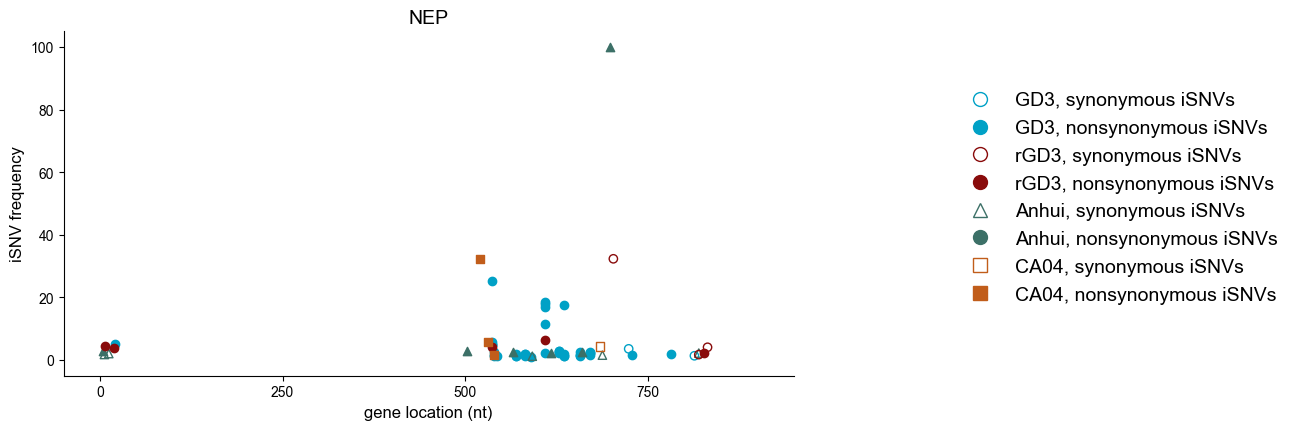

In [20]:
# define hex colors
GD3 = '#00A1C6'
rGD3 = '#890B0B'
Anhui = '#3C7067'
CA04 = '#C15D1A'

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(10,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 10)

ax1 = fig.add_subplot(gs[0,0:8]) #NEP

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# NEP (ax1) (GD3, Anhui, and CA04)
ax1.set_title('NEP', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-5,105)
ax1.set_xlim(-50,950)
ax1.set_xticks([0, 250, 500, 750])

ax1.scatter(x=GD3_NEP_s['nt'], y=GD3_NEP_s['avg'], marker='o', facecolors='none', edgecolors=GD3)
ax1.scatter(x=GD3_NEP_ns['nt'], y=GD3_NEP_ns['avg'], marker='o', facecolors=GD3, edgecolors=GD3)

ax1.scatter(x=Anhui_NEP_s['nt'], y=Anhui_NEP_s['avg'], marker='^', facecolors='none', edgecolors=Anhui)
ax1.scatter(x=Anhui_NEP_ns['nt'], y=Anhui_NEP_ns['avg'], marker='^', facecolors=Anhui, edgecolors=Anhui)

ax1.scatter(x=rGD3_NEP_s['nt'], y=rGD3_NEP_s['avg'], marker='o', facecolors='none', edgecolors=rGD3)
ax1.scatter(x=rGD3_NEP_ns['nt'], y=rGD3_NEP_ns['avg'], marker='o', facecolors=rGD3, edgecolors=rGD3)

ax1.scatter(x=CA04_NEP_s['nt'], y=CA04_NEP_s['avg'], marker='s', facecolors='none', edgecolors=CA04)
ax1.scatter(x=CA04_NEP_ns['nt'], y=CA04_NEP_ns['avg'], marker='s', facecolors=CA04, edgecolors=CA04)

ax1.set_ylabel('iSNV frequency', fontname='Arial', fontsize=12)
ax1.set_xlabel('gene location (nt)', fontname='Arial', fontsize=12)


# add a legend to this plot
GD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, synonymous iSNVs')
GD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=GD3, markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, nonsynonymous iSNVs')
rGD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, synonymous iSNVs')
rGD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=rGD3, markeredgecolor=rGD3, linestyle='None', markersize=10, label='rGD3, nonsynonymous iSNVs')
Anhui_syn = mlines.Line2D([], [], marker='^', markerfacecolor='None', markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, synonymous iSNVs')
Anhui_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=Anhui, markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, nonsynonymous iSNVs')
CA04_syn = mlines.Line2D([], [], marker='s', markerfacecolor='None', markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, synonymous iSNVs')
CA04_nonsyn = mlines.Line2D([], [], marker='s', markerfacecolor=CA04, markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, nonsynonymous iSNVs')

# line = mlines.Line2D([], [], marker='|', linestyle='None', color='grey', label='SNV freq range: average - max', markersize=14)
fig.legend(handles=[GD3_syn, GD3_nonsyn, rGD3_syn, rGD3_nonsyn, Anhui_syn, Anhui_nonsyn, CA04_syn, CA04_nonsyn], frameon=False, fontsize=14, bbox_to_anchor=(1.3,0.9))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/iSNVs_by_gene/NEP.pdf", bbox_inches='tight', dpi=300)
